This is a project to build a model that diagnoses eye conditions based on images of the anterior of the eye.
For this version we have a dataset with five different conditions, Cataract, Conjunctivitis, Eyelid, Normal and Uveitis.
For this model we are using a Sequential Convolutional Neural Network for this project.

In [19]:
# Step 1: Import Necessary Libraries
# In order to build the CNN, I need TensorFlow for the model, NumPy for data handling, cv2 for image processing, os for file manipulation,
# and Matplotlib for visualization.

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, Input

# Output version of TensorFlow being used
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.2


In [20]:
# Step 2a: Create the classes for the images based on the folder names with different conditions in each folder

# Set path for the director of the data set to be used
DATA_DIR = '/Users/aresbandebo/PycharmProjects/Eye_CNN_Testing/Dataset_Eye_Diseases_Classification/'

# Set the desired image dimensions for resizing.
IMG_HEIGHT = 224
IMG_WIDTH = 224

def create_classes_from_dirs(target_path):
    """
    Scans a target path and dynamically creates Python classes based on the names
    of the directories found within it.

    Args:
        target_path (str): The absolute or relative path to the directory to scan.

    Returns:
        dict: A dictionary containing the names and class objects that were created.
              Returns an empty dictionary if the path does not exist or contains no directories.
    """
    print(f"Attempting to scan for directories in: '{target_path}'")

    # --- 1. Validate the path ---
    if not os.path.isdir(target_path):
        print(f"\nError: The specified path does not exist or is not a directory.")
        print("Please make sure the path is correct and accessible.")
        return {}

    created_classes = {}

    # --- 2. Find all sub-directories ---
    try:
        # Get a list of all entries in the target_path and filter for directories
        dir_names = [name for name in os.listdir(target_path)
                     if os.path.isdir(os.path.join(target_path, name))]
    except OSError as e:
        print(f"\nError: Could not access the path. Reason: {e}")
        return {}

    if not dir_names:
        print("\nNo sub-directories were found in the specified path.")
        return {}

    print(f"\nFound {len(dir_names)} directories. Creating corresponding classes...")

    # --- 3. Create a class for each directory ---
    for dir_name in dir_names:
        # Sanitize the directory name to make it a valid Python class name
        # (e.g., "diabetic retinopathy" -> "Diabetic_retinopathy")
        class_name = re.sub(r'[^0-9a-zA-Z_]', '_', dir_name).capitalize()

        # If the first character is not a letter, prepend 'C' for 'Class'
        if not class_name[0].isalpha():
            class_name = 'C' + class_name

        # Dynamically create the class using the type() function
        # Format: type(ClassName, (BaseClasses,), {attributes_and_methods})
        new_class = type(class_name, (object,), {
            '__doc__': f'Dynamically generated class from the "{dir_name}" directory.',
            'source_directory': dir_name,
            'file_count': len(os.listdir(os.path.join(target_path, dir_name)))
        })

        # Add the new class to the global scope of this script, making it accessible
        globals()[class_name] = new_class
        created_classes[class_name] = new_class
        print(f"- Created class: {class_name}")

    return created_classes

# --- Main execution block ---
if __name__ == "__main__":

    # Generate the classes
    dynamic_classes = create_classes_from_dirs(DATA_DIR)

    # --- Verification Step ---
    # This section demonstrates how to use the dynamically created classes.
    if dynamic_classes:
        print("\n--- Verification ---")
        print("The classes have been created and are now available for use.")
        print("Let's inspect the first class that was created:\n")

        # Get the name of the first class from the dictionary
        first_class_name = list(dynamic_classes.keys())[0]

        # Access the class from the global scope using its name
        FirstClass = globals()[first_class_name]

        # Create an instance of the class
        instance = FirstClass()

        # Print some information about the instance and its class
        print(f"Class Name: {first_class_name}")
        print(f"Instance created: {instance}")
        print(f"Instance type: {type(instance)}")
        print(f"Class docstring: {instance.__doc__}")
        print(f"Original directory name: '{instance.source_directory}'")
        print(f"Number of files in directory: {instance.file_count}")

    if dynamic_classes:
        class_names = list(dynamic_classes.keys())
        class_names.sort()
        print("\n--- List of All Class Names ---")
        print("A list called 'class_names' has been created with the names of all generated classes.")
        print(class_names)

Attempting to scan for directories in: '/Users/aresbandebo/PycharmProjects/Eye_CNN_Testing/Dataset_Eye_Diseases_Classification/'

Found 5 directories. Creating corresponding classes...
- Created class: Cataract
- Created class: Uveitis
- Created class: Conjunctivitis
- Created class: Eyelid
- Created class: Normal

--- Verification ---
The classes have been created and are now available for use.
Let's inspect the first class that was created:

Class Name: Cataract
Instance created: <__main__.Cataract object at 0x1041e4530>
Instance type: <class '__main__.Cataract'>
Class docstring: Dynamically generated class from the "Cataract" directory.
Original directory name: 'Cataract'
Number of files in directory: 352

--- List of All Class Names ---
A list called 'class_names' has been created with the names of all generated classes.
['Cataract', 'Conjunctivitis', 'Eyelid', 'Normal', 'Uveitis']


In [21]:
# NEW Step 2b: Import Images from a data set where the different eye conditions have pictures in different directories.

def load_data(DATA_DIR):
    """
    Loads images and their corresponding labels from a directory.

    Args:
        data_dir (str): The path to the directory containing subdirectories
                        of images, where each subdirectory name is a class label.

    Returns:
        tuple: A tuple containing three lists:
               - images (list): A list of image data as numpy arrays.
               - labels (list): A list of corresponding string labels.
               - filepaths (list): A list of the full paths for each image.
    """
    images = []
    labels = []
    filepaths = [] # <-- ADDED: List to store file paths

    # Get the class names (folder names)
    for class_name in class_names:
        class_path = os.path.join(DATA_DIR, class_name)

        # Skip files that are not directories
        if not os.path.isdir(class_path):
            continue

        print(f"Loading images from: {class_name}")
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:
                # Read the image using OpenCV (which loads in BGR format)
                image_bgr = cv2.imread(image_path)

                # --- IMPORTANT COLOR CORRECTION ---
                image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

                # Resize the image to a consistent size
                resized_image_rgb = cv2.resize(image_rgb, (IMG_WIDTH, IMG_HEIGHT))

                # Append the image, its label, and its filepath
                images.append(resized_image_rgb)
                labels.append(class_name)
                filepaths.append(image_path) # <-- ADDED: Append the full path
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

    return images, labels, filepaths # <-- MODIFIED: Return filepaths

In [22]:
# NEW Step 3: Loading the images and splitting the data

if __name__ == "__main__":
    if not os.path.exists(DATA_DIR) or not os.path.isdir(DATA_DIR):
        print("ERROR: Please update the 'DATA_DIR' variable.")
    else:
        # 1. Load the images, labels, AND filepaths
        images, labels, filepaths = load_data(DATA_DIR) # <-- MODIFIED

        # 2. Convert lists to NumPy arrays
        images = np.array(images, dtype='float32')
        labels = np.array(labels)
        filepaths = np.array(filepaths) # <-- ADDED

        # 3. Normalize image data
        images /= 255.0

        # 4. Encode labels
        label_encoder = LabelEncoder()
        integer_labels = label_encoder.fit_transform(labels)
        num_classes = len(np.unique(integer_labels))
        categorical_labels = to_categorical(integer_labels, num_classes=num_classes)

        # 5. Split the data AND filepaths
        # First, split into temporary training (80%) and testing (20%)
        (X_train_temp, X_test, y_train_temp, y_test,
         X_train_temp_paths, X_test_paths) = train_test_split( # <-- MODIFIED
            images, categorical_labels, filepaths, # <-- filepaths ADDED here
            test_size=0.20, stratify=categorical_labels, random_state=42
        )

        # Then, split the temporary set into final training (60%) and validation (20%)
        (X_train, X_val, y_train, y_val,
         X_train_paths, X_val_paths) = train_test_split( # <-- MODIFIED
            X_train_temp, y_train_temp, X_train_temp_paths, # <-- paths ADDED here
            test_size=0.25, stratify=y_train_temp, random_state=42
        )

        # --- Output the results (no changes here, just for context) ---
        print("\\n--- Data Preprocessing Summary ---")
        print(f"Total images loaded: {len(images)}")
        # ... (rest of the print statements)

Loading images from: Cataract
Error loading image /Users/aresbandebo/PycharmProjects/Eye_CNN_Testing/Dataset_Eye_Diseases_Classification/Cataract/.DS_Store: OpenCV(4.12.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

Loading images from: Conjunctivitis
Loading images from: Eyelid
Loading images from: Normal
Loading images from: Uveitis
\n--- Data Preprocessing Summary ---
Total images loaded: 2089



Displaying a sample of training images...


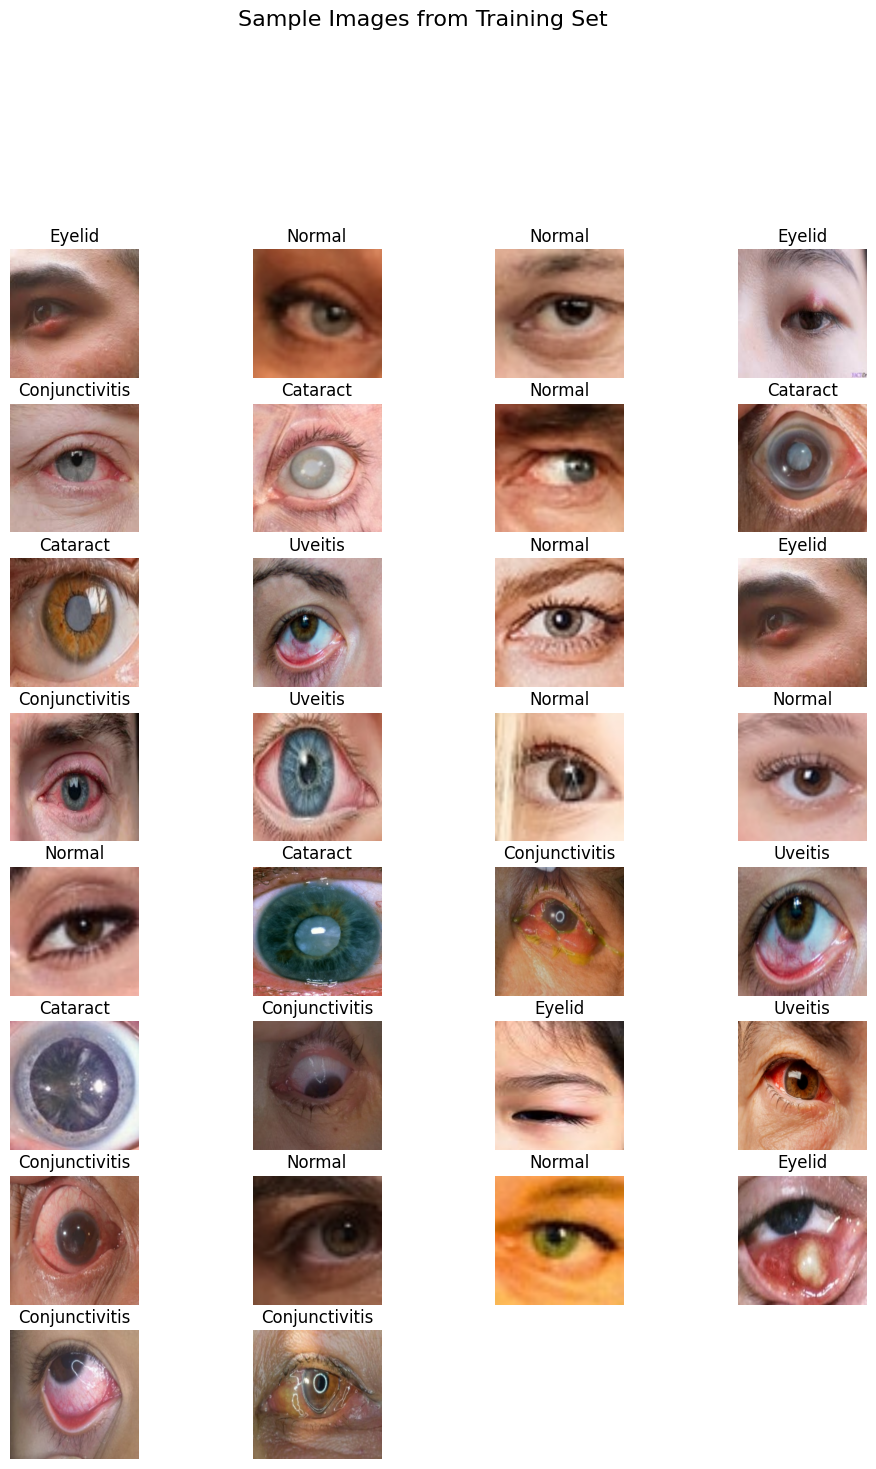

In [23]:
# Step 4: Display sample images
def show_sample_images(sample_images, sample_labels, class_names_map):
    plt.figure(figsize=(12, 120))
    for i in range(min(30, len(sample_images))): # Show up to 240 images
        plt.subplot(60, 4, i + 1)
        plt.imshow(sample_images[i])
        # Convert one-hot encoded label back to integer, then to class name
        label_index = np.argmax(sample_labels[i])
        plt.title(class_names_map[label_index])
        plt.axis("off")
    plt.suptitle("Sample Images from Training Set", fontsize=16, y=0.9)
    plt.show()

# Display some images from the training set to verify
print("\nDisplaying a sample of training images...")
show_sample_images(X_train, y_train, label_encoder.classes_)

In [24]:
# NEW Step 5: Define and Compile the CNN Model

# --- 1. Define the model architecture ---
model = models.Sequential([
    # Input layer
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # --- FIX: Add a Flatten layer ---
    # This layer flattens the 3D output from the conv blocks into a 1D vector
    layers.Flatten(),

    # Fully Connected (Dense) Layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])


# --- 2. Compile the model ---
model.compile(
    optimizer='adam',
    # --- FIX: Use 'categorical_crossentropy' or from_logits=False ---
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# --- 3. Print the model summary ---
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,077 (49.36 MB)

 Trainable params: 12,939,077 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Step 6: Compile the Model
# We configure the model for training.

model.compile(optimizer='adam',
              # For this loss function, it's good practice to set from_logits=True
              # because our model's output layer doesn't have a softmax activation function.
              # This can sometimes be more numerically stable.
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [26]:
    # Step 7: Train the Model
# We train for 10 epochs

print("\nStarting model training...")
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val))
print("Model training finished.")




Starting model training...
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:675: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.2546 - loss: 2.1530 - val_accuracy: 0.4856 - val_loss: 1.4520
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 355ms/step - accuracy: 0.4249 - loss: 1.3994 - val_accuracy: 0.4019 - val_loss: 1.4241
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 359ms/step - accuracy: 0.5419 - loss: 1.1757 - val_accuracy: 0.6077 - val_loss: 0.9377
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms/step - accuracy: 0.6178 - loss: 0.9600 - val_accuracy: 0.7129 - val_loss: 0.8099
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 358ms/step - accuracy: 0.7333 - loss: 0.7388 - val_accuracy: 0.7775 - val_loss: 0.6403
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 360ms/step - accuracy: 0.7747 - loss: 0.6294 - val_accuracy: 0.7584 - val_loss: 0.6939
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 359ms/step - accuracy: 0.7833 - loss: 0.6072 - val_accuracy: 0.7656 - val_loss: 0.6342
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 359ms/step - accuracy: 0.8252 - loss: 0.5015 - val_accuracy: 0.820

In [27]:
# Step 8: Evaluate the Model
# Check the final performance on the test set.

print("\nEvaluating model on the test dataset...")
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Note: My target is to get 70% accuracy or more on CIFAR-10.




Evaluating model on the test dataset...
14/14 - 1s - 86ms/step - accuracy: 0.8445 - loss: 0.5053

Test accuracy: 0.8445
Test loss: 0.5053


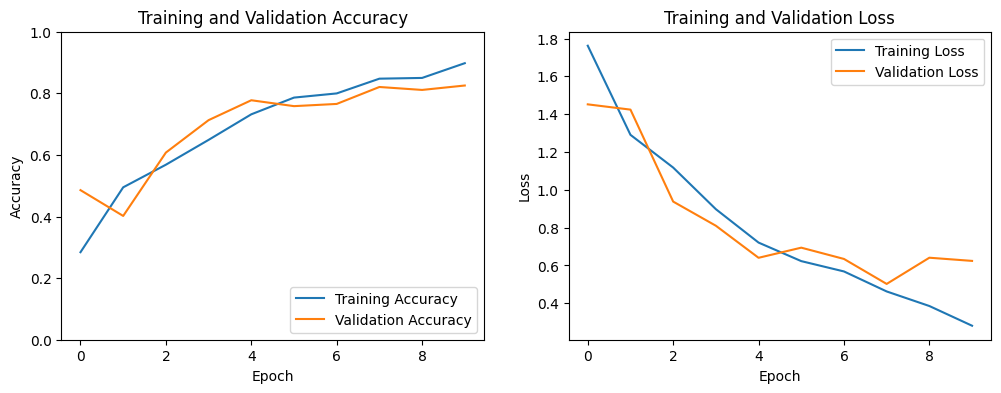

In [28]:
# Step 9: Visualize Training Results
# Plotting the history helps us understand the training process.

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

plt.show()



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


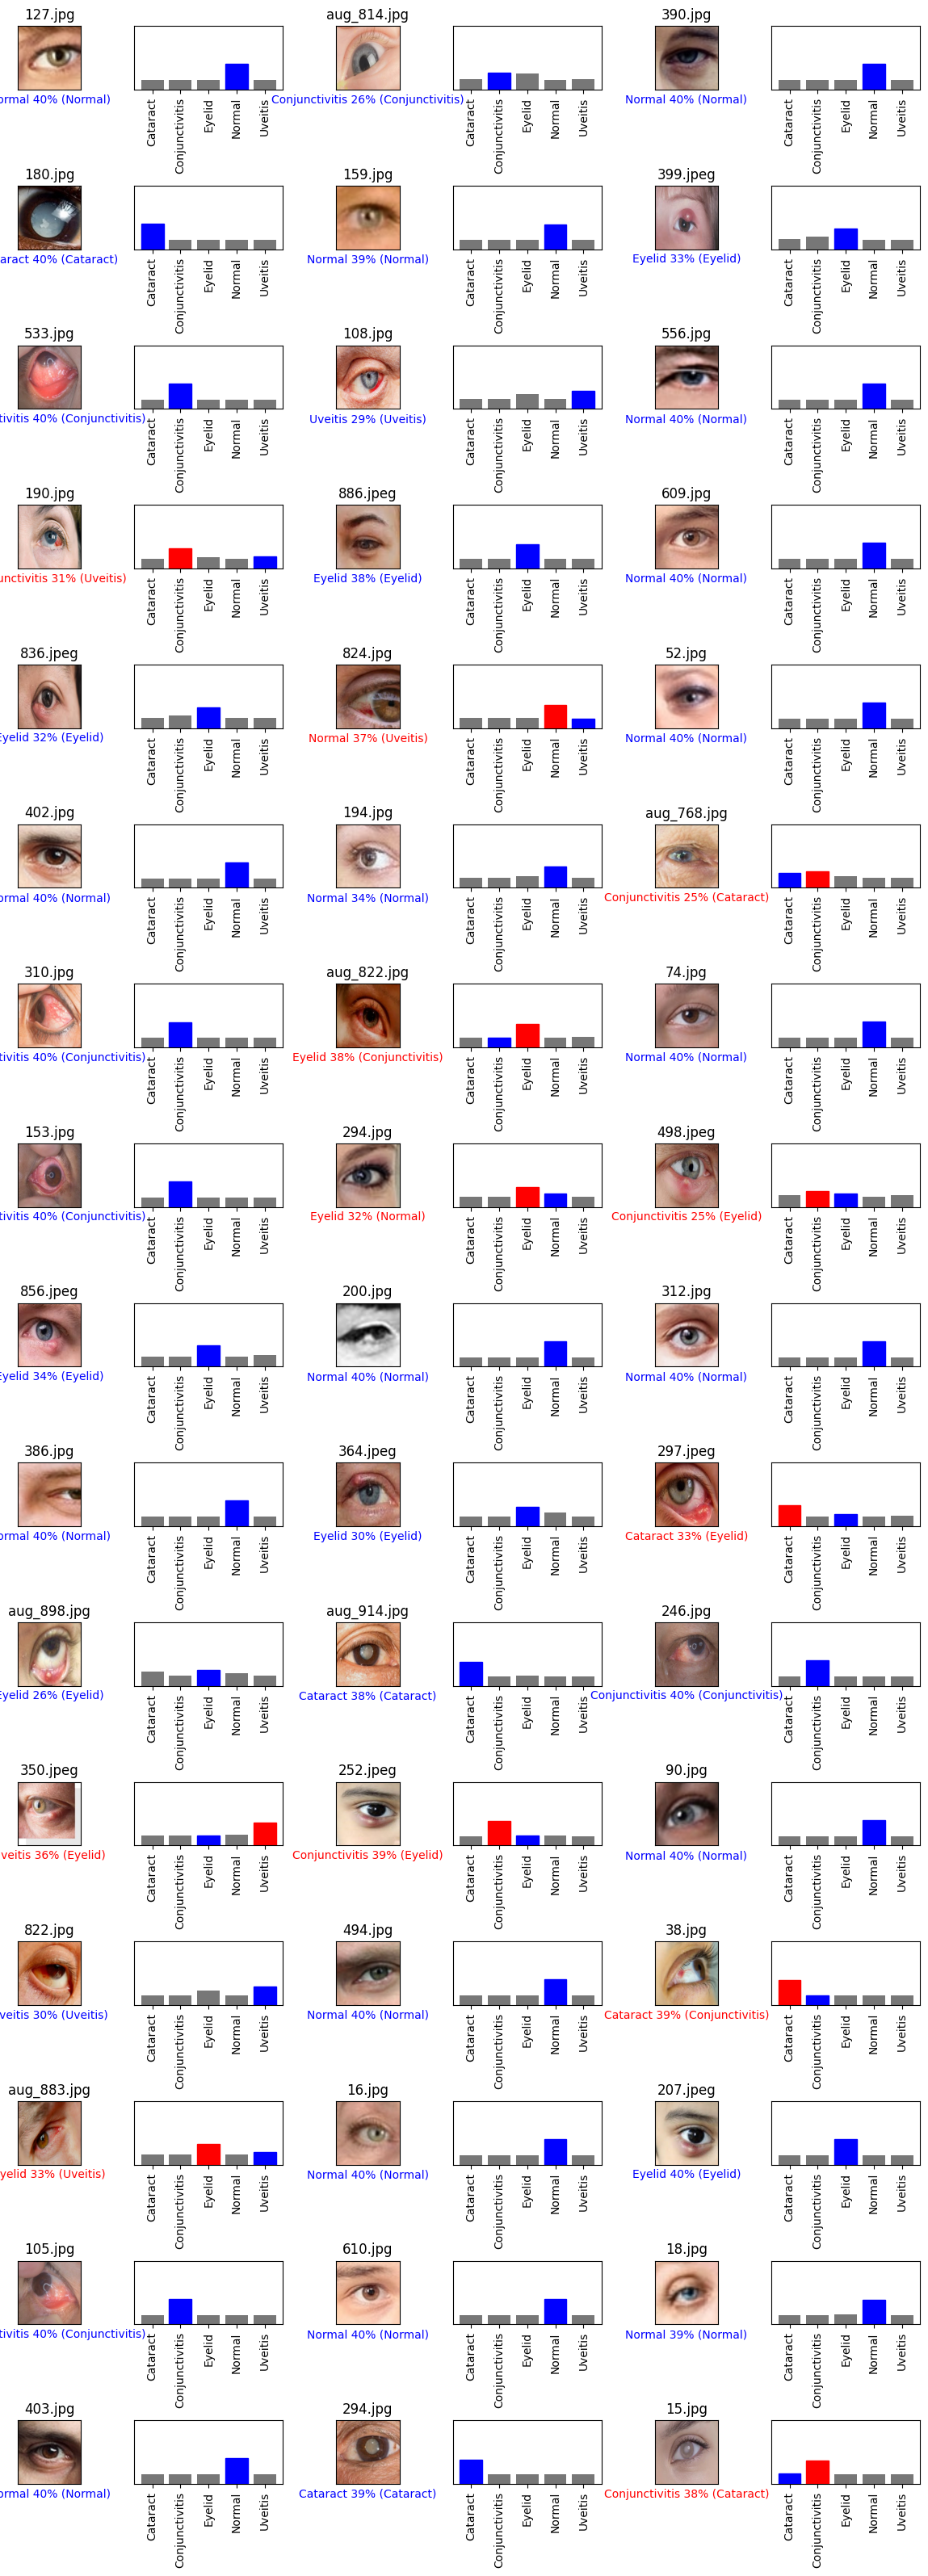

In [29]:
# NEW Step 10: Show a sample of the test data and results

probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test)


def plot_image_refactored(predictions_array, true_label, img, class_names, filename):
    try:
        true_label = np.argmax(true_label)
    except (ValueError, TypeError):
        true_label = int(true_label)

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    plt.title(os.path.basename(filename)) # ADDED: Display the filename (without the path) as the title

    predicted_label = np.argmax(predictions_array)
    color = 'blue' if predicted_label == true_label else 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100 * np.max(predictions_array),
                                         class_names[true_label]),
               color=color)

# No changes needed in plot_value_array_refactored
def plot_value_array_refactored(predictions_array, true_label, class_names):
    num_classes = len(class_names)
    try:
        true_label = np.argmax(true_label)
    except (ValueError, TypeError):
        true_label = int(true_label)
    class_names = label_encoder.classes_
    plt.grid(False)
    plt.xticks(range(num_classes), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


# The plotting loop
num_rows = 16
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)

    # MODIFIED: Pass the filename from X_test_paths to the function
    plot_image_refactored(predictions[i], y_test[i], X_test[i], class_names, X_test_paths[i])
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array_refactored(predictions[i], y_test[i], class_names)
plt.tight_layout()
plt.show()


In [30]:
# Step 11: Print the results for the test, trainging and validation

# Get the last value in the list for each metric
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# The model.evaluate() function returns the loss and accuracy on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

print("--- Training / Validation Results (from final epoch) and Final Test Results ---")
# Print the final accuracy values
print(f"Final Training Accuracy: {final_train_acc:.2%}")
print(f"Final Validation Accuracy: {final_val_acc:.2%}")
print(f"Test Accuracy: {test_acc:.2%}")
print("-" * 50)

# Print the final loss values
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print("\n" + "=" * 50 + "\n")  # Add a major separator



14/14 - 1s - 90ms/step - accuracy: 0.8445 - loss: 0.5053
--- Training / Validation Results (from final epoch) and Final Test Results ---
Final Training Accuracy: 89.78%
Final Validation Accuracy: 82.54%
Test Accuracy: 84.45%
--------------------------------------------------
Final Training Loss: 0.2810
Final Validation Loss: 0.6239
Test Loss: 0.5053


